In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# Loading data
mort = pd.read_csv('../data/apache_patient_result_data.csv')
finGCS = pd.read_csv('../data/loaded/final_gcs.csv')
finGCS = finGCS.loc[:, ['patientunitstayid', 'Value']]
mort = mort.drop_duplicates('patientunitstayid')
mort['death'] = mort['actualhospitalmortality'] != 'ALIVE'
mort['los'] = mort['actualhospitallos'].astype(float)
mort = mort.loc[:, ['patientunitstayid', 'death', 'los']]
mort = mort.merge(finGCS, on = 'patientunitstayid', how = 'left')
mort = mort.dropna()
mort['GCS'] = mort['Value'] != 6
display(mort)

losAlive = mort[mort['death'] == False].loc[:, ['los']].values
losDeath = mort[mort['death'] == True].loc[:, ['los']].values
# plt.figure(figsize = (8, 8))
# plt.boxplot([losAlive, losDeath], labels = ["Alive", "Dead"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs mortality", size = 16)
# plt.ylim((0, 25))
#plt.savefig("LOSvsMort.png", bbox_inches = 'tight')

# mort = mort[mort['death']]
display(mort)


los1 = mort[mort['Value'] == 1].loc[:, ['los']].values
los2 = mort[mort['Value'] == 2].loc[:, ['los']].values
los3 = mort[mort['Value'] == 3].loc[:, ['los']].values
los4 = mort[mort['Value'] == 4].loc[:, ['los']].values
los5 = mort[mort['Value'] == 5].loc[:, ['los']].values
los6 = mort[mort['Value'] == 6].loc[:, ['los']].values

# plt.figure(figsize = (8, 8))
# plt.boxplot([los1, los2, los3, los4, los5, los6], labels = ["1", "2", "3", "4", "5", "6"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs final GCS", size = 16)
# plt.ylim((0, 35))
#plt.savefig("LOSvsGCS.png", bbox_inches = 'tight')

,patientunitstayid,death,los,Value,GCS
1,1015921,False,3.4118,6.0,False
2,1823818,False,4.7326,6.0,False
4,2228330,False,45.5549,2.0,True
5,3073401,False,9.9813,6.0,False
6,3199652,False,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,False,5.1590,6.0,False
4501,2712577,False,3.2410,6.0,False
4502,1791019,False,0.8715,6.0,False
4503,2263791,False,10.7319,6.0,False


,patientunitstayid,death,los,Value,GCS
1,1015921,False,3.4118,6.0,False
2,1823818,False,4.7326,6.0,False
4,2228330,False,45.5549,2.0,True
5,3073401,False,9.9813,6.0,False
6,3199652,False,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,False,5.1590,6.0,False
4501,2712577,False,3.2410,6.0,False
4502,1791019,False,0.8715,6.0,False
4503,2263791,False,10.7319,6.0,False


In [4]:
# Settings
mort_features = False
los_features = False

In [5]:
# Gathering the rest of data
ap = pd.read_csv('../data/loaded/processed/aperiodic_processed.csv')
ap = ap.iloc[:, [0, 2, 3, 4]]
ap = ap.set_index('patientunitstayid').add_prefix("AP_")

dem = pd.read_csv('../data/loaded/processed/dem_processed.csv')
dem = dem.set_index('patientunitstayid').add_prefix("DEM_")

inf = pd.read_csv('../data/loaded/processed/infusion_processed.csv')
inf = inf.set_index('patientunitstayid').add_prefix("INF_")

lab = pd.read_csv('../data/loaded/processed/lab_processed.csv')
lab = lab.set_index('patientunitstayid').add_prefix("LAB_")

med = pd.read_csv('../data/loaded/processed/medication_processed.csv')
med = med.set_index('patientunitstayid').add_prefix("MED_")

nc = pd.read_csv('../data/loaded/processed/nc_processed.csv')
nc['verbal'][nc['verbal'] > 6] = 6
nc['eyes'][nc['eyes'] > 6] = 6
nc = nc.iloc[:, [0, 2, 3, 4]]
nc = nc.fillna(nc.mean())
nc = nc.set_index('patientunitstayid').add_prefix("NC_")

resp = pd.read_csv('../data/loaded/processed/respiratory_processed.csv')
pd.set_option('display.max_columns', None)
resp.iloc[:, 1:] = resp.iloc[:, 1:] > 0
resp['entries'] = resp.iloc[:, 1:].sum(axis = 1) > 0
resp = resp.iloc[:, [0, 27]]
resp = resp.set_index('patientunitstayid').add_prefix("resp_")

X_ts = pd.read_csv('../data/loaded/processed/ts_processed.csv')
X_hr = X_ts[['patientunitstayid', 'offset_bin', 'hr']].pivot(index='patientunitstayid',
            columns='offset_bin', values='hr').reset_index()
X_resp = X_ts[['patientunitstayid', 'offset_bin', 'resp']].pivot(index='patientunitstayid',
            columns='offset_bin', values='resp').reset_index()
X_sao2 = X_ts[['patientunitstayid', 'offset_bin', 'sao2']].pivot(index='patientunitstayid',
            columns='offset_bin', values='sao2').reset_index()
X_gcs = X_ts[['patientunitstayid', 'offset_bin', 'gcs']].pivot(index='patientunitstayid',
            columns='offset_bin', values='gcs').reset_index()
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] > 6] = 6
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] < 1] = 1

pca = PCA(n_components = 5)
hrp = pca.fit_transform(X_hr.iloc[:, 1:])
respp = pca.fit_transform(X_resp.iloc[:, 1:])

sao2p = pca.fit_transform(X_sao2.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("sao2 PCA 0")
# plt.stem(pca.components_[0, :])

gcsp = pca.fit_transform(X_gcs.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("GCS PCA 0")
# plt.stem(pca.components_[0, :])


hr = pd.DataFrame(hrp)
hr.columns = ['hr0', 'hr1', 'hr2', 'hr3', 'hr4']
hr['patientunitstayid'] = X_hr['patientunitstayid']

resp = pd.DataFrame(respp)
resp.columns = ['resp0', 'resp1', 'resp2', 'resp3', 'resp4']
resp['patientunitstayid'] = X_resp['patientunitstayid']

sao2 = pd.DataFrame(sao2p)
sao2.columns = ['sao20', 'sao21', 'sao22', 'sao23', 'sao24']
sao2['patientunitstayid'] = X_sao2['patientunitstayid']

gcs = pd.DataFrame(gcsp)
gcs.columns = ['gcs0', 'gcs1', 'gcs2', 'gcs3', 'gcs4']
gcs['patientunitstayid'] = X_gcs['patientunitstayid']

X = gcs.set_index('patientunitstayid').merge(hr.set_index('patientunitstayid'), how = 'left', left_index = True, right_index = True).merge(resp.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True).merge(sao2.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True)
Xn = X.merge(nc, how = 'left',left_index = True, right_index = True).merge(med,  how = 'left',left_index = True, right_index = True).merge(lab, how = 'left',left_index = True, right_index = True).merge(inf,  how = 'left',left_index = True, right_index = True).merge(dem,  how = 'left',left_index = True, right_index = True).merge(ap,  how = 'left',left_index = True, right_index = True)

# Mort Features
if mort_features:
    Xn = Xn[['DEM_age', 'gcs0', 'INF_norepinephrine','INF_morphine', 'LAB_BUN', 'LAB_glucose', 'sao20', 'INF_phenylephrine', 'MED_4846.0', 'LAB_paCO2']]

# LOS Features
elif los_features:
    Xn = Xn[['gcs0', 'MED_549.0', 'MED_2102.0', 'MED_1326.0', 'MED_25386.0', 'LAB_HCO3', 'LAB_Hct', 'LAB_O2 Sat (%)', 'LAB_Hgb', 'LAB_-lymphs']]

Xn = Xn.reset_index()

#out = GCS, los, death
out = "los"
Y = Xn.merge(mort)[out].values
Xns = Xn.merge(mort).iloc[:, :-4]
Xns = Xns.fillna(Xns.mean())
display(Y)
display(Xns)

X = Xns.drop('patientunitstayid', axis = 1).values
Xn = Xns.drop('patientunitstayid', axis = 1)

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([ 6.9319,  6.8625, 10.0014, ...,  7.6736, 14.9396,  4.1521])

,patientunitstayid,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,resp0,resp1,resp2,resp3,resp4,sao20,sao21,sao22,sao23,sao24,NC_verbal,NC_eyes,NC_temp,MED_89.0,MED_549.0,MED_610.0,MED_926.0,MED_1301.0,MED_1326.0,MED_1694.0,MED_1730.0,MED_1866.0,MED_2095.0,MED_2102.0,MED_4521.0,MED_4846.0,MED_8255.0,MED_19078.0,MED_20952.0,MED_22008.0,MED_25386.0,MED_33598.0,MED_35085.0,LAB_-basos,LAB_-eos,LAB_-lymphs,LAB_-monos,LAB_-polys,LAB_ALT (SGPT),LAB_AST (SGOT),LAB_BUN,LAB_Base Excess,LAB_FiO2,LAB_HCO3,LAB_Hct,LAB_Hgb,LAB_MCH,LAB_MCHC,LAB_MCV,LAB_MPV,LAB_O2 Sat (%),LAB_PT,LAB_PT - INR,LAB_PTT,LAB_RBC,LAB_RDW,LAB_WBC x 1000,LAB_albumin,LAB_alkaline phos.,LAB_anion gap,LAB_bedside glucose,LAB_bicarbonate,LAB_calcium,LAB_chloride,LAB_creatinine,LAB_glucose,LAB_magnesium,LAB_pH,LAB_paCO2,LAB_paO2,LAB_phosphate,LAB_platelets x 1000,LAB_potassium,LAB_sodium,LAB_total bilirubin,LAB_total protein,INF_fentanyl,INF_insulin,INF_midazolam,INF_morphine,INF_nicardipine,INF_norepinephrine,INF_phenylephrine,INF_propofol,INF_redbloodcell,INF_sodium,INF_vasopressin,DEM_age,DEM_admissionheight,DEM_admissionweight,DEM_gender,AP_sys,AP_dias,AP_bp
0,172448,21.395486,0.270489,0.140389,-0.132050,-0.127288,-6.178157,-33.565423,14.478594,6.298156,9.661218,-5.941014,-2.791063,4.270180,-4.158885,3.218815,0.664032,6.172689,-6.065610,0.335125,0.406888,1.000000,1.000000,97.50000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.00,8.00,10.00,82.00,27.25,27.25,24.5,7.0,80.00,30.0,31.9,11.15,30.2,35.1,86.0,27.25,27.25,27.25,27.25,27.25,3.71,18.80,12.2,27.25,27.25,8.5,128.800000,30.75,8.95,110.75,1.5725,129.0,2.20,7.5000,39.00,117.0,27.25,90.0,3.5375,146.75,27.25,27.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,177.80,96.40,1,147.000000,81.500000,108.000000
1,242714,-3.097281,0.190085,-0.071351,-0.041548,0.014308,83.766630,-11.347911,2.104468,1.484385,3.001636,80.552517,17.688065,12.332894,13.061354,-7.332299,14.836540,-4.314695,1.254915,1.123612,0.035656,4.000000,4.000000,97.30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0.10,11.30,9.10,78.50,11.00,16.00,14.0,12.6,12.60,12.6,36.1,12.00,32.2,33.2,96.8,12.60,12.60,15.90,1.20,12.60,3.73,12.60,10.8,4.00,51.00,11.0,122.000000,28.00,8.80,97.00,0.6000,131.0,12.60,12.6000,12.60,12.6,12.60,205.0,4.5000,136.00,1.00,6.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,182.90,89.20,1,126.760870,81.652174,98.695652
2,242825,-3.097281,0.190085,-0.071351,-0.041548,0.014308,-10.112928,-10.793130,1.791431,-10.294472,-9.548381,18.659311,-12.257058,6.507007,-2.699533,2.172383,15.488906,0.039786,-1.278880,1.702790,-2.185135,3.882891,3.648673,79.19525,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.20,1.80,8.80,8.20,80.40,44.00,26.00,24.0,1.5,24.00,26.5,29.7,9.60,29.0,32.2,90.0,24.00,89.35,14.60,1.10,27.00,3.31,13.50,8.7,3.20,79.00,10.0,251.250000,27.00,8.20,101.00,0.8000,141.0,1.80,7.3800,46.00,63.0,24.00,142.0,4.7000,138.00,0.30,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,193.04,102.05,1,113.434783,58.434783,77.391304
3,243176,-3.097281,0.190085,-0.071351,-0.041548,0.014308,55.533416,31.960579,-14.284974,17.193942,-9.264705,-24.269052,-9.072793,8.133088,17.456511,-5.986560,-0.213224,4.566932,4.906911,-1.222528,2.398273,5.000000,3.000000,97.80000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.00,3.70,7.40,88.20,14.00,14.00,9.0,14.0,28.00,14.0,31.4,10.30,30.9,32.8,94.3,14.00,14.00,14.00,14.00,14.00,3.33,14.00,10.9,14.00,14.00,8.0,14.000000,22.00,6.80,108.00,0.6000,124.0,14.00,14.0000,14.00,14.0,14.00,134.0,3.9000,138.00,14.00,14.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,170.20,88.90,-1,130.696429,77.839286,98.875000
4,243493,-3.097281,0.190085,-0.071351,-0.041548,0.014308,-59.499693,2.779041,31.849218,0.576501,4.750410,-9.538096,-0.654340,-0.282225,-1.298385,5.617293,15.203610,1.582982,-2.962954,2.309826,-1.960484,6.000000,6.000000,98.20000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0

In [6]:
death = list(mort['death'])
los = list(mort['los'])
y = [(death[i], los[i]) for i in range(len(death))]
print(y)
print(pd.Series(y))

[(False, 3.4118), (False, 4.7326), (False, 45.5549), (False, 9.9813), (False, 11.8257), (False, 8.0104), (False, 2.7264), (False, 1.0625), (False, 22.3424), (False, 14.0375), (False, 28.8104), (False, 3.0167), (False, 13.6479), (False, 8.7438), (False, 46.8181), (False, 5.809), (False, 10.7319), (False, 4.4806), (False, 7.2986), (False, 7.8389), (True, 0.6549), (False, 2.4056), (False, 39.3347), (False, 3.466), (False, 14.7375), (False, 14.6986), (False, 5.7806), (True, 0.5646), (True, 0.7368), (True, 1.8715), (False, 14.9208), (False, 9.5521), (False, 1.0153), (False, 24.016), (True, 7.8694), (True, 23.5292), (False, 4.9292), (False, 5.0292), (False, 44.4854), (False, 10.7604), (False, 1.0056), (False, 1.4354), (False, 4.4799), (False, 6.1181), (False, 15.4625), (True, 1.3486), (False, 3.7917), (False, 32.7875), (True, 3.2417), (True, 39.5132), (False, 1.2813), (False, 28.1292), (True, 2.2986), (True, 1.3396), (False, 1.6549), (False, 2.4958), (False, 50.0), (False, 26.9313), (False, 

In [7]:
display(mort)
mort_surv_tble_forR = mort.copy()
newdeath = []
for d in death:
    if d == True:
        newdeath.append(1)
    else:
        newdeath.append(0)
mort_surv_tble_forR['death'] = newdeath
display(mort_surv_tble_forR)
mort_surv_tble_forR.to_csv('mort_surv_analysis_data.csv')

# Also creating inputs for LOS estimate
occurs = [1] * len(death)
los_tble_forR = mort.copy()
los_tble_forR['occurs'] = occurs
los_tble_forR = los_tble_forR.drop(columns=['death'])
display(los_tble_forR)
los_tble_forR.to_csv('los_surv_analysis_dat.csv')

,patientunitstayid,death,los,Value,GCS
1,1015921,False,3.4118,6.0,False
2,1823818,False,4.7326,6.0,False
4,2228330,False,45.5549,2.0,True
5,3073401,False,9.9813,6.0,False
6,3199652,False,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,False,5.1590,6.0,False
4501,2712577,False,3.2410,6.0,False
4502,1791019,False,0.8715,6.0,False
4503,2263791,False,10.7319,6.0,False


,patientunitstayid,death,los,Value,GCS
1,1015921,0,3.4118,6.0,False
2,1823818,0,4.7326,6.0,False
4,2228330,0,45.5549,2.0,True
5,3073401,0,9.9813,6.0,False
6,3199652,0,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,0,5.1590,6.0,False
4501,2712577,0,3.2410,6.0,False
4502,1791019,0,0.8715,6.0,False
4503,2263791,0,10.7319,6.0,False


,patientunitstayid,los,Value,GCS,occurs
1,1015921,3.4118,6.0,False,1
2,1823818,4.7326,6.0,False,1
4,2228330,45.5549,2.0,True,1
5,3073401,9.9813,6.0,False,1
6,3199652,11.8257,6.0,False,1
...,...,...,...,...,...
4498,1451537,5.1590,6.0,False,1
4501,2712577,3.2410,6.0,False,1
4502,1791019,0.8715,6.0,False,1
4503,2263791,10.7319,6.0,False,1


In [8]:
# Finding number who were alive by end of hospital stay
num_alive = sum([i == False for i in death])
num_dead = sum(death)

print("Num alive: %d" % num_alive)
print("Num dead: %d" % num_dead)

Num alive: 1902
Num dead: 308


Text(0.5, 1.0, 'Survival Curve for Patient Sample')

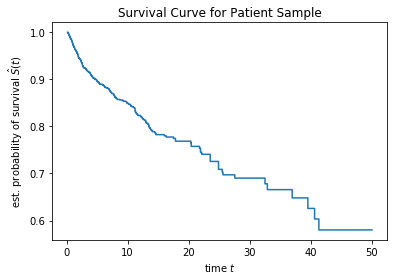

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(death, los)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival Curve for Patient Sample')

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,242714,False,6.8625,6.0,False
2,242825,False,10.0014,6.0,False
3,243176,False,6.5340,6.0,False
4,243493,False,2.5028,6.0,False
...,...,...,...,...,...
1684,3350835,False,6.0063,6.0,False
1685,3351268,False,8.2465,6.0,False
1686,3351909,False,7.6736,6.0,False
1687,3352618,False,14.9396,6.0,False


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


Text(0.5, 1.0, 'Survival Curves by Age')

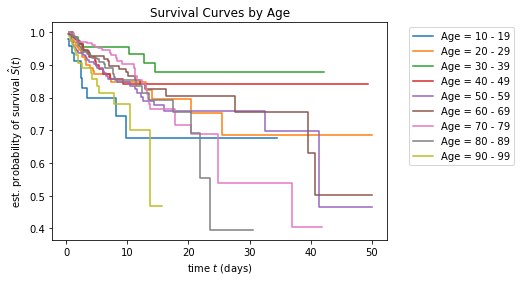

In [10]:
ages = list(range(0, 110, 10))
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])
print(ages)

for i in range(len(ages)-1):
    mask_treat_lower = list(Xns['DEM_age'] >= ages[i])
    mask_treat_upper = list(Xns['DEM_age'] < ages[i+1])
    mask_treat = [mask_treat_lower[i] and mask_treat_upper[i] for i in range(len(mask_treat_lower))]
    if sum(mask_treat) == 0:
        continue
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        np.array(death)[mask_treat],
        np.array(los)[mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Age = %s - %s" % (ages[i], ages[i+1]-1))

# plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")
# plt.legend(loc ="best")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Survival Curves by Age')

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,242714,False,6.8625,6.0,False
2,242825,False,10.0014,6.0,False
3,243176,False,6.5340,6.0,False
4,243493,False,2.5028,6.0,False
...,...,...,...,...,...
1684,3350835,False,6.0063,6.0,False
1685,3351268,False,8.2465,6.0,False
1686,3351909,False,7.6736,6.0,False
1687,3352618,False,14.9396,6.0,False


[1, -1, 0]


Text(0.5, 1.0, 'Survival Curves by Gender')

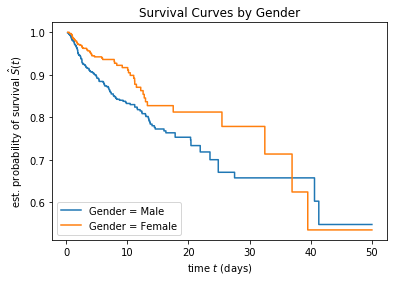

In [11]:
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
genders = list(Xns['DEM_gender'].drop_duplicates())
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])

print(genders)
for g in genders:
    mask_treat = list(Xns['DEM_gender'] == g)
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        np.array(death)[mask_treat],
        np.array(los)[mask_treat])
    if g == 1:
        label = "Male"
    elif g == -1:
        label = "Female"
    elif g == 0:
#         label = "Other"
        continue

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Gender = %s" % label)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")
plt.legend(loc="lower left")
plt.title('Survival Curves by Gender')

In [12]:
mort_surv_tble_forR = pd.merge(Xns, mort, how='inner')
newdeath = []
for d in list(mort_surv_tble_forR['death']):
    if d == True:
        newdeath.append(1)
    else:
        newdeath.append(0)
mort_surv_tble_forR['death'] = newdeath
display(mort_surv_tble_forR)
mort_surv_tble_forR.to_csv('mort_surv_analysis_data.csv')

# Also creating inputs for LOS estimate
los_tble_forR = pd.merge(Xns, mort, how='inner')
occurs = [1] * los_tble_forR.shape[0]
los_tble_forR['occurs'] = occurs
los_tble_forR = los_tble_forR.drop(columns=['death'])
display(los_tble_forR)
los_tble_forR.to_csv('los_surv_analysis_dat.csv')

,patientunitstayid,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,resp0,resp1,resp2,resp3,resp4,sao20,sao21,sao22,sao23,sao24,NC_verbal,NC_eyes,NC_temp,MED_89.0,MED_549.0,MED_610.0,MED_926.0,MED_1301.0,MED_1326.0,MED_1694.0,MED_1730.0,MED_1866.0,MED_2095.0,MED_2102.0,MED_4521.0,MED_4846.0,MED_8255.0,MED_19078.0,MED_20952.0,MED_22008.0,MED_25386.0,MED_33598.0,MED_35085.0,LAB_-basos,LAB_-eos,LAB_-lymphs,LAB_-monos,LAB_-polys,LAB_ALT (SGPT),LAB_AST (SGOT),LAB_BUN,LAB_Base Excess,LAB_FiO2,LAB_HCO3,LAB_Hct,LAB_Hgb,LAB_MCH,LAB_MCHC,LAB_MCV,LAB_MPV,LAB_O2 Sat (%),LAB_PT,LAB_PT - INR,LAB_PTT,LAB_RBC,LAB_RDW,LAB_WBC x 1000,LAB_albumin,LAB_alkaline phos.,LAB_anion gap,LAB_bedside glucose,LAB_bicarbonate,LAB_calcium,LAB_chloride,LAB_creatinine,LAB_glucose,LAB_magnesium,LAB_pH,LAB_paCO2,LAB_paO2,LAB_phosphate,LAB_platelets x 1000,LAB_potassium,LAB_sodium,LAB_total bilirubin,LAB_total protein,INF_fentanyl,INF_insulin,INF_midazolam,INF_morphine,INF_nicardipine,INF_norepinephrine,INF_phenylephrine,INF_propofol,INF_redbloodcell,INF_sodium,INF_vasopressin,DEM_age,DEM_admissionheight,DEM_admissionweight,DEM_gender,AP_sys,AP_dias,AP_bp,death,los,Value,GCS
0,172448,21.395486,0.270489,0.140389,-0.132050,-0.127288,-6.178157,-33.565423,14.478594,6.298156,9.661218,-5.941014,-2.791063,4.270180,-4.158885,3.218815,0.664032,6.172689,-6.065610,0.335125,0.406888,1.000000,1.000000,97.50000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.00,8.00,10.00,82.00,27.25,27.25,24.5,7.0,80.00,30.0,31.9,11.15,30.2,35.1,86.0,27.25,27.25,27.25,27.25,27.25,3.71,18.80,12.2,27.25,27.25,8.5,128.800000,30.75,8.95,110.75,1.5725,129.0,2.20,7.5000,39.00,117.0,27.25,90.0,3.5375,146.75,27.25,27.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,177.80,96.40,1,147.000000,81.500000,108.000000,1,6.9319,1.0,True
1,242714,-3.097281,0.190085,-0.071351,-0.041548,0.014308,83.766630,-11.347911,2.104468,1.484385,3.001636,80.552517,17.688065,12.332894,13.061354,-7.332299,14.836540,-4.314695,1.254915,1.123612,0.035656,4.000000,4.000000,97.30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0.10,11.30,9.10,78.50,11.00,16.00,14.0,12.6,12.60,12.6,36.1,12.00,32.2,33.2,96.8,12.60,12.60,15.90,1.20,12.60,3.73,12.60,10.8,4.00,51.00,11.0,122.000000,28.00,8.80,97.00,0.6000,131.0,12.60,12.6000,12.60,12.6,12.60,205.0,4.5000,136.00,1.00,6.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,182.90,89.20,1,126.760870,81.652174,98.695652,0,6.8625,6.0,False
2,242825,-3.097281,0.190085,-0.071351,-0.041548,0.014308,-10.112928,-10.793130,1.791431,-10.294472,-9.548381,18.659311,-12.257058,6.507007,-2.699533,2.172383,15.488906,0.039786,-1.278880,1.702790,-2.185135,3.882891,3.648673,79.19525,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.20,1.80,8.80,8.20,80.40,44.00,26.00,24.0,1.5,24.00,26.5,29.7,9.60,29.0,32.2,90.0,24.00,89.35,14.60,1.10,27.00,3.31,13.50,8.7,3.20,79.00,10.0,251.250000,27.00,8.20,101.00,0.8000,141.0,1.80,7.3800,46.00,63.0,24.00,142.0,4.7000,138.00,0.30,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,193.04,102.05,1,113.434783,58.434783,77.391304,0,10.0014,6.0,False
3,243176,-3.097281,0.190085,-0.071351,-0.041548,0.014308,55.533416,31.960579,-14.284974,17.193942,-9.264705,-24.269052,-9.072793,8.133088,17.456511,-5.986560,-0.213224,4.566932,4.906911,-1.222528,2.398273,5.000000,3.000000,97.80000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.00,3.70,7.40,88.20,14.00,14.00,9.0,14.0,28.00,14.0,31.4,10.30,30.9,32.8,94.3,14.00,14.00,14.00,14.00,14.00,3.33,14.00,10.9,14.00,14.00,8.0,14.000000,22.00,6.80,108.00,0.6000,124.0,14.00,14.0000,14.00,14.0,14.00,134.0,3.9000,138.00,14.00,14.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,170.20,88.90,-1,130.696429,77.839286,98.875000,0,6.5340,6.0,False
4,243493,-3.097281,0.190085,-0.071351,-0.041548,0.014308,-59.499693,2.779041,31.849218,0.576501,4.750410,-9.538096,-0.654340,-0.282225,-1.298385,5.617293,15.20361

,patientunitstayid,gcs0,gcs1,gcs2,gcs3,gcs4,hr0,hr1,hr2,hr3,hr4,resp0,resp1,resp2,resp3,resp4,sao20,sao21,sao22,sao23,sao24,NC_verbal,NC_eyes,NC_temp,MED_89.0,MED_549.0,MED_610.0,MED_926.0,MED_1301.0,MED_1326.0,MED_1694.0,MED_1730.0,MED_1866.0,MED_2095.0,MED_2102.0,MED_4521.0,MED_4846.0,MED_8255.0,MED_19078.0,MED_20952.0,MED_22008.0,MED_25386.0,MED_33598.0,MED_35085.0,LAB_-basos,LAB_-eos,LAB_-lymphs,LAB_-monos,LAB_-polys,LAB_ALT (SGPT),LAB_AST (SGOT),LAB_BUN,LAB_Base Excess,LAB_FiO2,LAB_HCO3,LAB_Hct,LAB_Hgb,LAB_MCH,LAB_MCHC,LAB_MCV,LAB_MPV,LAB_O2 Sat (%),LAB_PT,LAB_PT - INR,LAB_PTT,LAB_RBC,LAB_RDW,LAB_WBC x 1000,LAB_albumin,LAB_alkaline phos.,LAB_anion gap,LAB_bedside glucose,LAB_bicarbonate,LAB_calcium,LAB_chloride,LAB_creatinine,LAB_glucose,LAB_magnesium,LAB_pH,LAB_paCO2,LAB_paO2,LAB_phosphate,LAB_platelets x 1000,LAB_potassium,LAB_sodium,LAB_total bilirubin,LAB_total protein,INF_fentanyl,INF_insulin,INF_midazolam,INF_morphine,INF_nicardipine,INF_norepinephrine,INF_phenylephrine,INF_propofol,INF_redbloodcell,INF_sodium,INF_vasopressin,DEM_age,DEM_admissionheight,DEM_admissionweight,DEM_gender,AP_sys,AP_dias,AP_bp,los,Value,GCS,occurs
0,172448,21.395486,0.270489,0.140389,-0.132050,-0.127288,-6.178157,-33.565423,14.478594,6.298156,9.661218,-5.941014,-2.791063,4.270180,-4.158885,3.218815,0.664032,6.172689,-6.065610,0.335125,0.406888,1.000000,1.000000,97.50000,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.00,0.00,8.00,10.00,82.00,27.25,27.25,24.5,7.0,80.00,30.0,31.9,11.15,30.2,35.1,86.0,27.25,27.25,27.25,27.25,27.25,3.71,18.80,12.2,27.25,27.25,8.5,128.800000,30.75,8.95,110.75,1.5725,129.0,2.20,7.5000,39.00,117.0,27.25,90.0,3.5375,146.75,27.25,27.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,177.80,96.40,1,147.000000,81.500000,108.000000,6.9319,1.0,True,1
1,242714,-3.097281,0.190085,-0.071351,-0.041548,0.014308,83.766630,-11.347911,2.104468,1.484385,3.001636,80.552517,17.688065,12.332894,13.061354,-7.332299,14.836540,-4.314695,1.254915,1.123612,0.035656,4.000000,4.000000,97.30000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40,0.10,11.30,9.10,78.50,11.00,16.00,14.0,12.6,12.60,12.6,36.1,12.00,32.2,33.2,96.8,12.60,12.60,15.90,1.20,12.60,3.73,12.60,10.8,4.00,51.00,11.0,122.000000,28.00,8.80,97.00,0.6000,131.0,12.60,12.6000,12.60,12.6,12.60,205.0,4.5000,136.00,1.00,6.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,182.90,89.20,1,126.760870,81.652174,98.695652,6.8625,6.0,False,1
2,242825,-3.097281,0.190085,-0.071351,-0.041548,0.014308,-10.112928,-10.793130,1.791431,-10.294472,-9.548381,18.659311,-12.257058,6.507007,-2.699533,2.172383,15.488906,0.039786,-1.278880,1.702790,-2.185135,3.882891,3.648673,79.19525,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.20,1.80,8.80,8.20,80.40,44.00,26.00,24.0,1.5,24.00,26.5,29.7,9.60,29.0,32.2,90.0,24.00,89.35,14.60,1.10,27.00,3.31,13.50,8.7,3.20,79.00,10.0,251.250000,27.00,8.20,101.00,0.8000,141.0,1.80,7.3800,46.00,63.0,24.00,142.0,4.7000,138.00,0.30,6.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,193.04,102.05,1,113.434783,58.434783,77.391304,10.0014,6.0,False,1
3,243176,-3.097281,0.190085,-0.071351,-0.041548,0.014308,55.533416,31.960579,-14.284974,17.193942,-9.264705,-24.269052,-9.072793,8.133088,17.456511,-5.986560,-0.213224,4.566932,4.906911,-1.222528,2.398273,5.000000,3.000000,97.80000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.00,3.70,7.40,88.20,14.00,14.00,9.0,14.0,28.00,14.0,31.4,10.30,30.9,32.8,94.3,14.00,14.00,14.00,14.00,14.00,3.33,14.00,10.9,14.00,14.00,8.0,14.000000,22.00,6.80,108.00,0.6000,124.0,14.00,14.0000,14.00,14.0,14.00,134.0,3.9000,138.00,14.00,14.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,170.20,88.90,-1,130.696429,77.839286,98.875000,6.5340,6.0,False,1
4,243493,-3.097281,0.190085,-0.071351,-0.041548,0.014308,-59.499693,2.779041,31.849218,0.576501,4.750410,-9.538096,-0.654340,-0.282225,-1.298385,5.617293,15.2036

In [13]:
# Getting y values
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])
y = np.array([(death[i], los[i]) for i in range(len(death))], dtype=[('Status', 'bool'), ('Survival_in_days', 'float')])

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,242714,False,6.8625,6.0,False
2,242825,False,10.0014,6.0,False
3,243176,False,6.5340,6.0,False
4,243493,False,2.5028,6.0,False
...,...,...,...,...,...
1684,3350835,False,6.0063,6.0,False
1685,3351268,False,8.2465,6.0,False
1686,3351909,False,7.6736,6.0,False
1687,3352618,False,14.9396,6.0,False


In [430]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

yclass = np.array(death)
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.3, random_state=6)
trainpredsss = []
testpredsss = []
trainlabsss = []
testlabsss = []
i = 0

best_y_pred = []
best_concordance = 0

metrics = []
scaler = StandardScaler()
coefs = np.zeros((20, X.shape[1]))
for train_index, test_index in sss.split(X, yclass):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = CoxnetSurvivalAnalysis()
    model2 = CoxnetSurvivalAnalysis(fit_baseline_model=True)
    model.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    survival = model2.predict_survival_function(X_test)
    y_pred = model.predict(X_test)
    
    metrics.append(metric)
    if (metric[0] > best_concordance):
        best_concordance = metric[0]
        best_y_pred = y_pred
        
y_pred = best_y_pred

C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_feat

C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_feat

In [431]:
print(metrics)
print()
concordances = [m[0] for m in metrics]
print(np.mean(concordances))

[(0.8898373167302671, 17722, 2194, 0, 3), (0.8557195952921742, 16577, 2795, 0, 1), (0.8982450965934228, 18273, 2070, 0, 1), (0.8410870333888973, 16651, 3146, 0, 3), (0.8637339055793991, 17710, 2794, 0, 0), (0.8347395271264594, 17017, 3369, 0, 1), (0.8145421324161651, 15157, 3451, 0, 4), (0.8566659712080117, 16424, 2748, 0, 1), (0.8592989028632593, 16056, 2629, 0, 0), (0.8774304231795654, 18412, 2572, 0, 2), (0.8662222222222222, 17541, 2709, 0, 2), (0.886129585925767, 16521, 2123, 0, 3), (0.8340904174778283, 15424, 3068, 0, 2), (0.8529454475047195, 17621, 3038, 0, 0), (0.8506260206859009, 15626, 2744, 0, 2), (0.8508843406988449, 17752, 3111, 0, 1), (0.8836736668924804, 18262, 2404, 0, 0), (0.8402851877000679, 17325, 3293, 0, 0), (0.8599595827188814, 15745, 2564, 0, 0), (0.8822270952559234, 16495, 2202, 0, 0)]

0.8599171735730131


6.7319
False


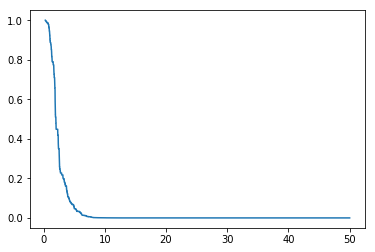

17.8361
True


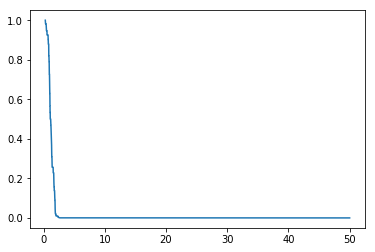

predict death
[1.8194 1.8292 1.8313]

7.2438
True


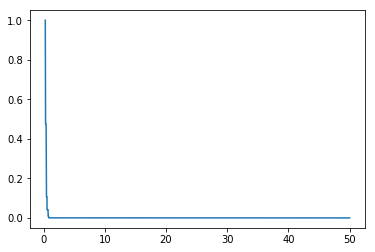

predict death
[0.4764 0.5049 0.5118 0.5354 0.5563 0.5625]

16.0069
True


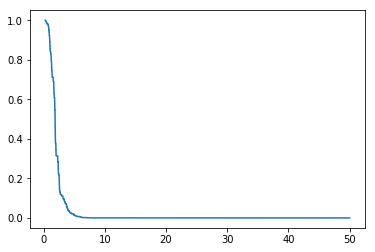

predict death
[3.1576]

13.7785
False


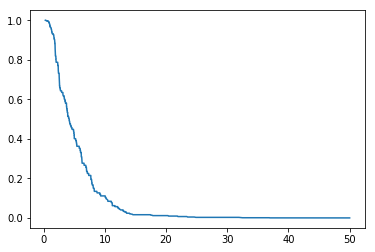

4.9549
False


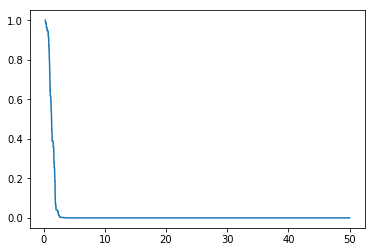

predict death
[1.9125 1.9153]

4.5813
False


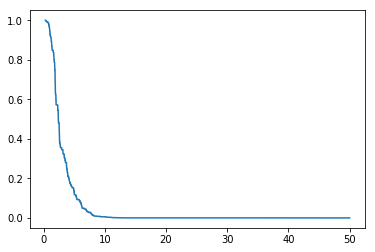

7.3118
False


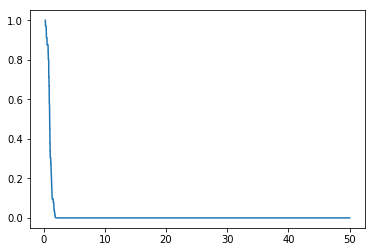

predict death
[1.3903 1.4035 1.4069 1.4313 1.4326 1.4563 1.4861 1.4917 1.5035 1.5264
 1.5271 1.5313 1.55   1.5632]

2.1444
True


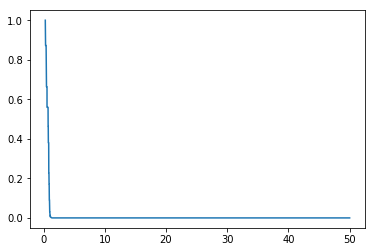

predict death
[0.9208 0.9382 0.9396 0.9403 0.9597 0.9674]

17.0604
False


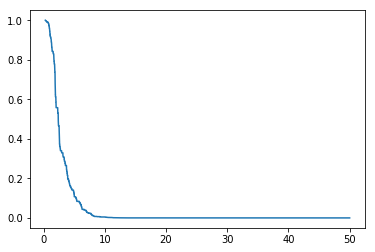

2.4667
False


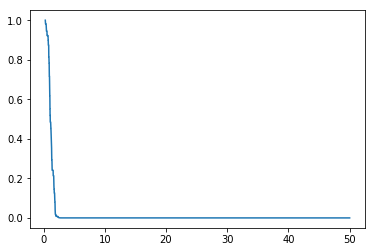

predict death
[1.8194 1.8292 1.8313]

1.9681
False


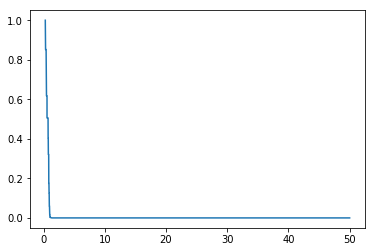

predict death
[0.9201]

9.8688
False


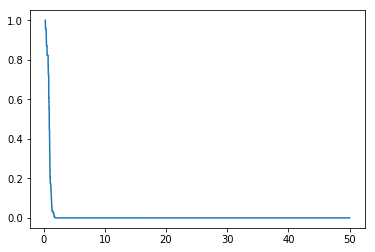

predict death
[1.2583 1.2813]

4.7438
False


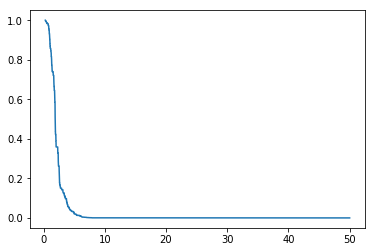

13.1201
False


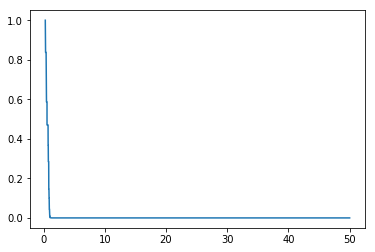

predict death
[0.8861 0.8924 0.8993 0.9    0.9132 0.916 ]

4.8514
False


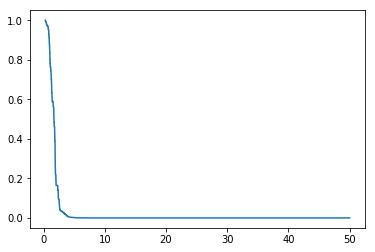

predict death
[2.4194]

46.8181
False


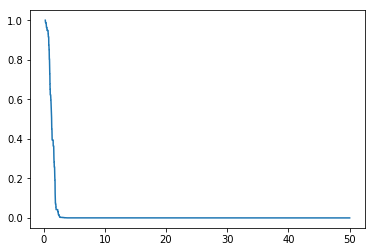

predict death
[1.9125 1.9153]

12.841
False


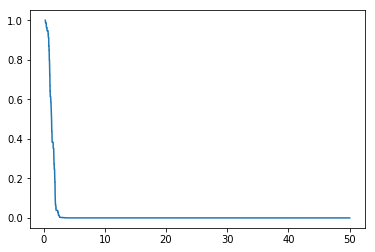

predict death
[1.9083]

3.509
False


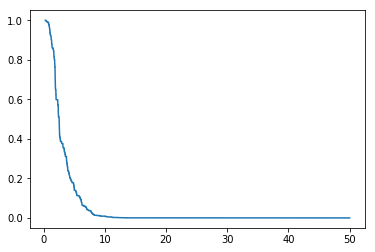

5.9819
False


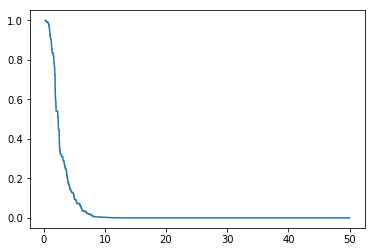

2.7979
False


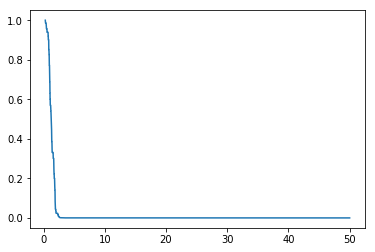

predict death
[1.8833 1.8896]

7.0486
False


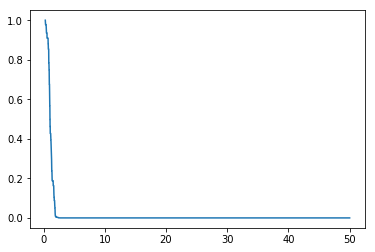

predict death
[1.7028 1.7118 1.7222 1.7257 1.7278 1.7292 1.7326]

22.2188
False


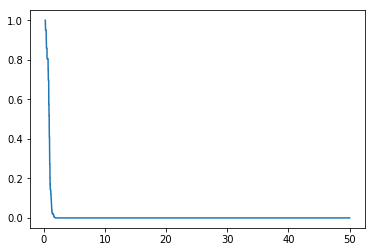

predict death
[1.2396 1.2472]

0.6042
False


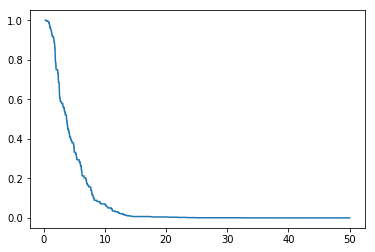

14.7083
False


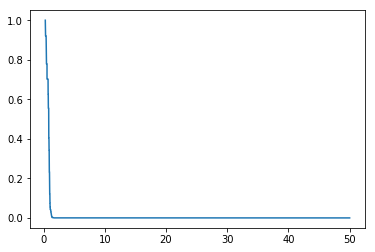

predict death
[1.0319]

13.4514
False


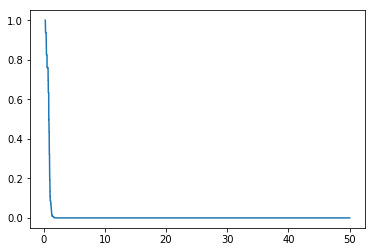

predict death
[1.0597 1.0833]

1.9347
True


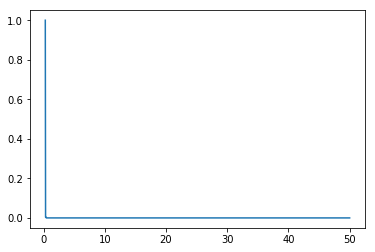

predict death
[0.3271 0.4153]

3.5083
False


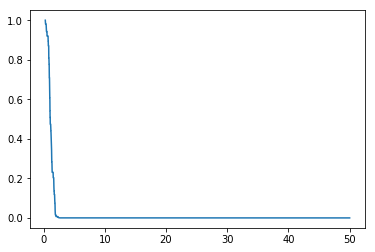

predict death
[1.809  1.8174]

1.5514
True


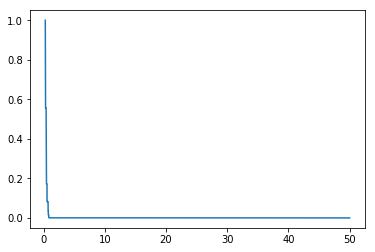

predict death
[0.5646 0.6646 0.7049 0.709  0.7194 0.7333]

7.1257
False


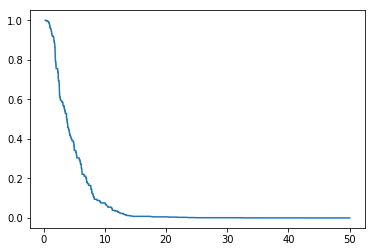

3.2438
True


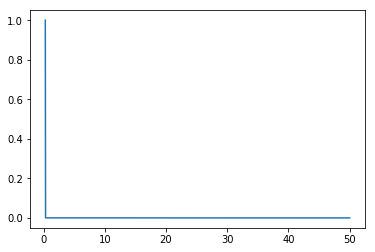

predict death
[0.3271 0.4153]

8.8458
False


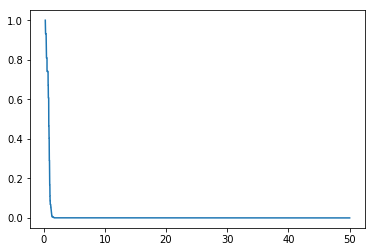

predict death
[1.0465 1.0583]

4.5917
True


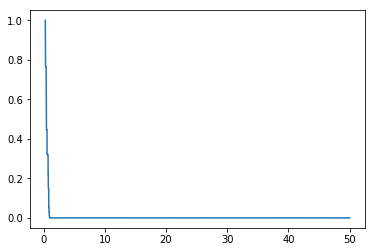

predict death
[0.8382 0.8389]

10.0785
False


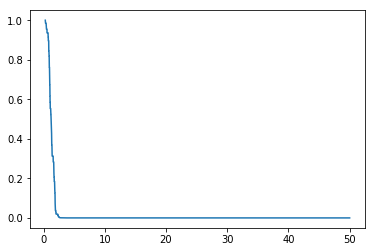

predict death
[1.8764 1.8785]

4.6819
False


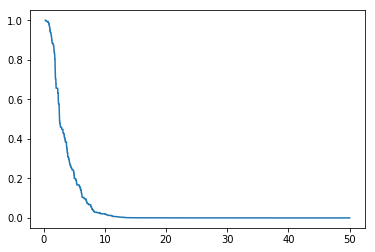

7.1479
False


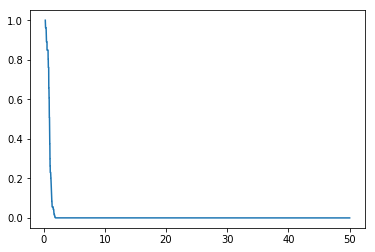

predict death
[1.3188]

39.5132
True


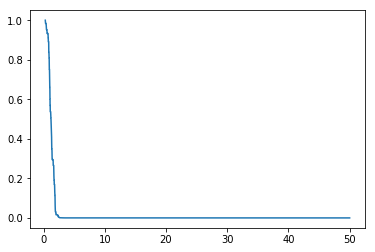

predict death
[1.8715]

8.0319
False


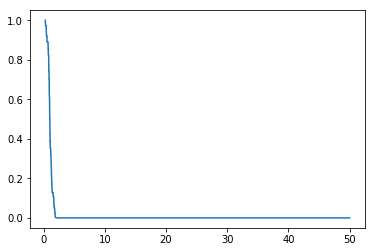

predict death
[1.5715 1.5792 1.5965 1.6007 1.6326 1.6521 1.6542 1.6549 1.6556]

0.7417
False


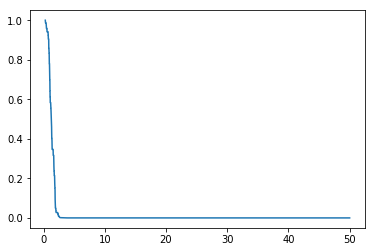

predict death
[1.8833 1.8896]

1.5229
False


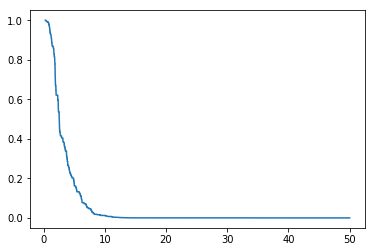

27.5493
True


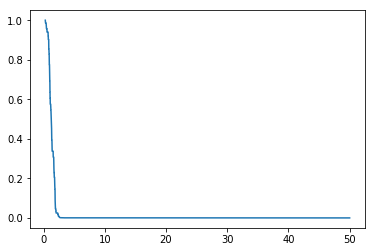

predict death
[1.8833 1.8896]

0.5042
True


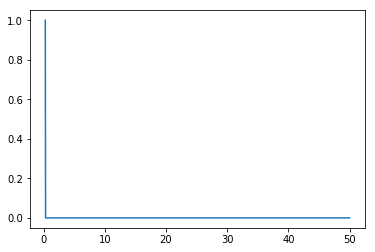

predict death
[0.3271 0.4153]

2.634
False


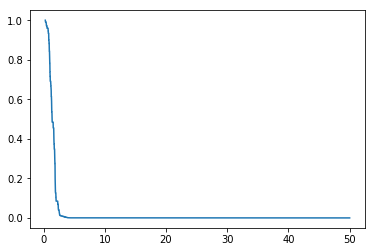

predict death
[2.0063 2.0083 2.0111 2.016  2.0215 2.0264 2.0313]

6.8889
False


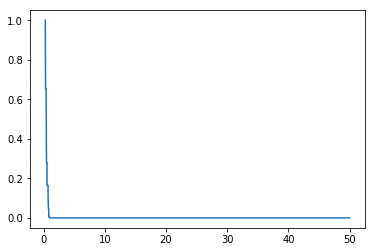

predict death
[0.7368 0.7472 0.7611 0.7639]

4.6167
False


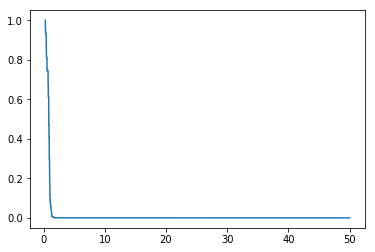

predict death
[1.0597 1.0833]

2.1653
False


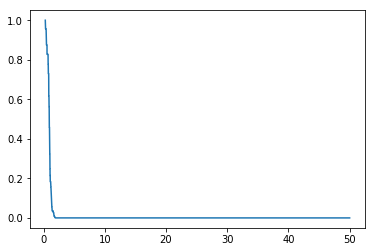

predict death
[1.2583 1.2813]

3.3271
False


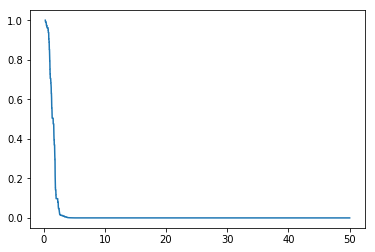

predict death
[2.0542 2.0646 2.0889 2.091  2.1125 2.1292 2.1333 2.1438 2.1479 2.1618
 2.1708 2.1785 2.2028 2.2104 2.2493 2.2535 2.2549 2.3035 2.3056]

4.7313
False


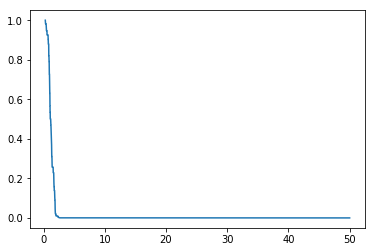

predict death
[1.8194 1.8292 1.8313]

9.3278
False


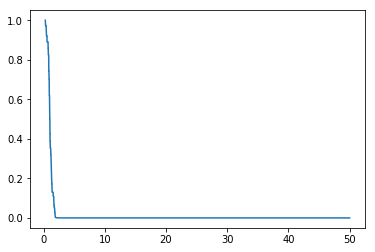

predict death
[1.6639]

12.7333
False


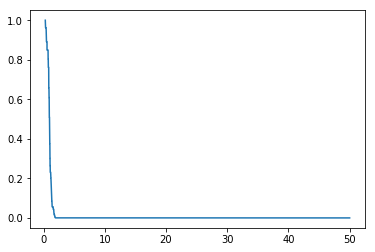

predict death
[1.3188]

2.3549
False


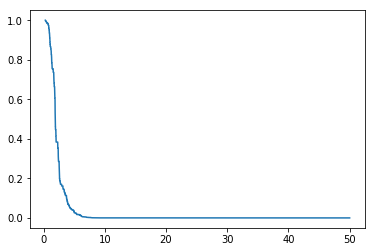

10.7104
False


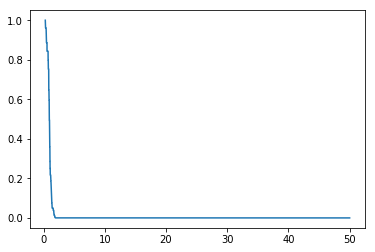

predict death
[1.3188]

7.5201
False


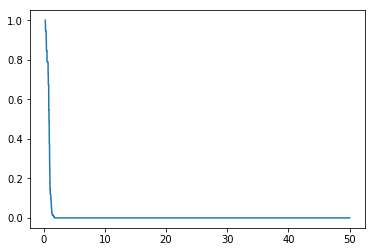

predict death
[1.1799 1.1875 1.1958 1.2056]

3.4965
False


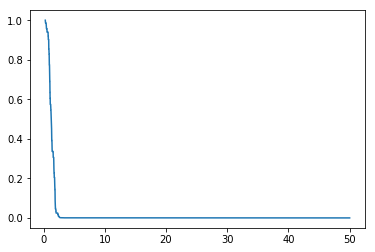

predict death
[1.8833 1.8896]

2.3229
False


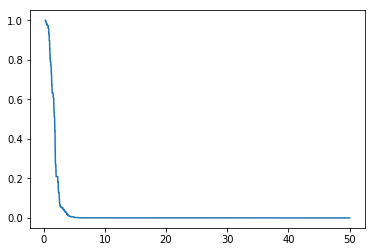

predict death
[2.5778 2.5875]

14.7354
False


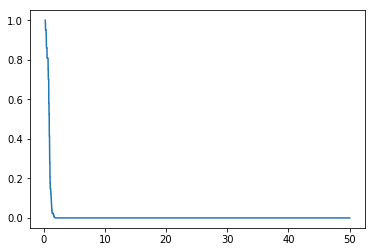

predict death
[1.2396 1.2472]

4.5278
False


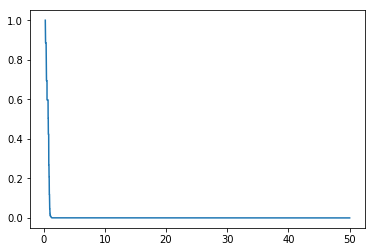

predict death
[0.9785]

17.0188
False


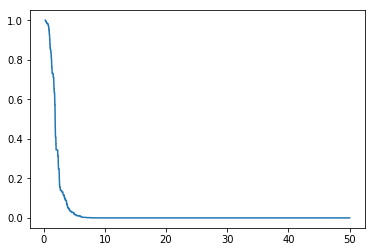

22.3424
False


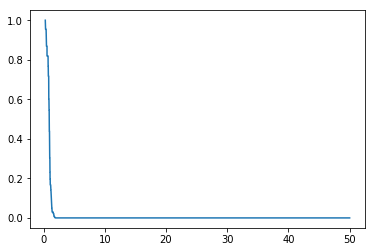

predict death
[1.2583 1.2813]

3.9771
False


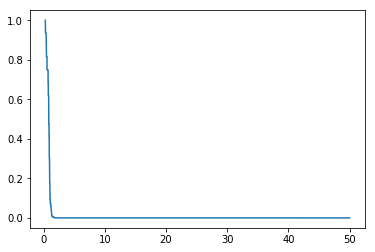

predict death
[1.0597 1.0833]

19.9556
False


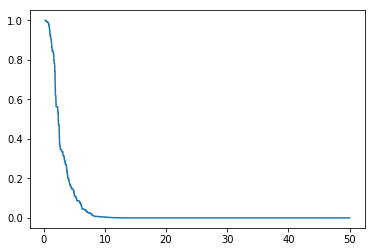

2.0326
False


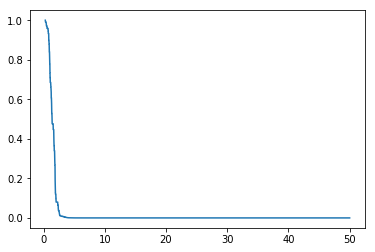

predict death
[2.0063 2.0083 2.0111 2.016  2.0215 2.0264 2.0313]

5.6083
False


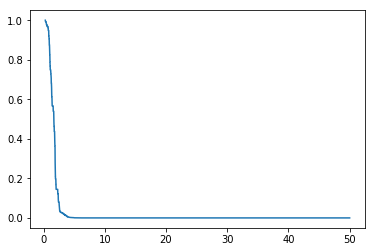

predict death
[2.3965 2.3979]

15.9104
False


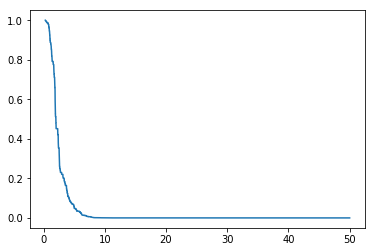

5.6611
False


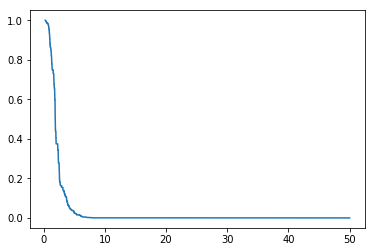

1.3333
False


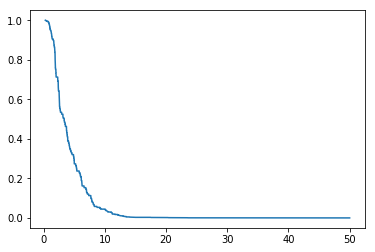

8.875
False


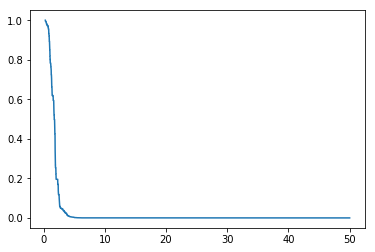

predict death
[2.5465 2.55  ]

7.7722
False


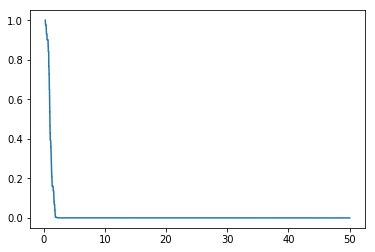

predict death
[1.6729 1.6743 1.6778 1.6792 1.6882]

4.0
True


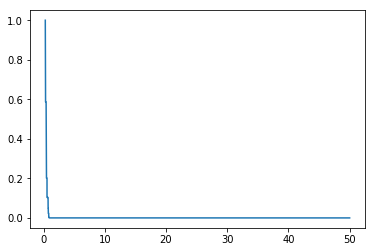

predict death
[0.5646 0.6646 0.7049 0.709  0.7194 0.7333]

7.0389
False


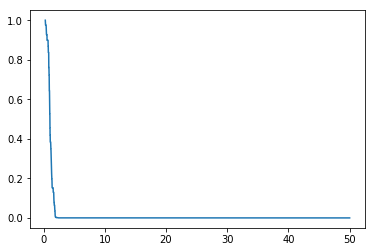

predict death
[1.6729 1.6743 1.6778 1.6792 1.6882]

22.2951
False


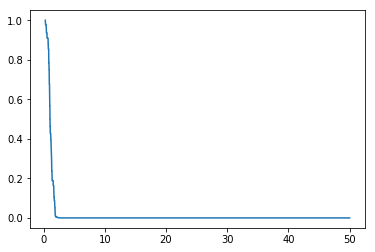

predict death
[1.7028 1.7118 1.7222 1.7257 1.7278 1.7292 1.7326]

11.1333
False


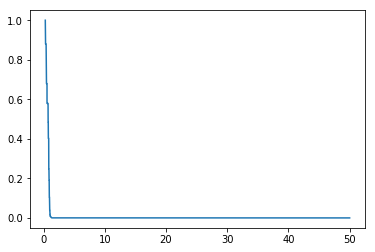

predict death
[0.9208 0.9382 0.9396 0.9403 0.9597 0.9674]

11.6208
False


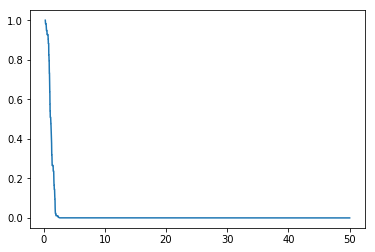

predict death
[1.8479 1.8493 1.8556 1.8694]

5.1896
False


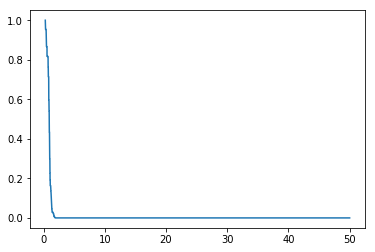

predict death
[1.2583 1.2813]

11.0215
False


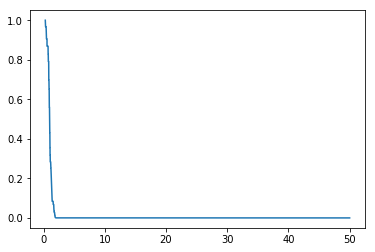

predict death
[1.3778 1.3854]

5.0521
False


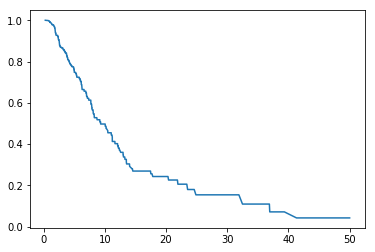

7.6465
False


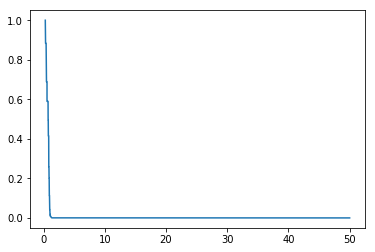

predict death
[0.9208 0.9382 0.9396 0.9403 0.9597 0.9674]

10.216000000000001
False


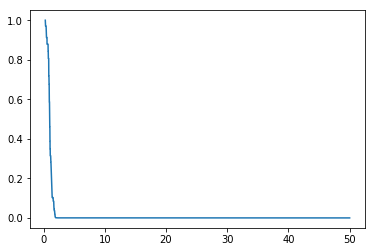

predict death
[1.3903 1.4035 1.4069 1.4313 1.4326 1.4563 1.4861 1.4917 1.5035 1.5264
 1.5271 1.5313 1.55   1.5632]

20.9611
False


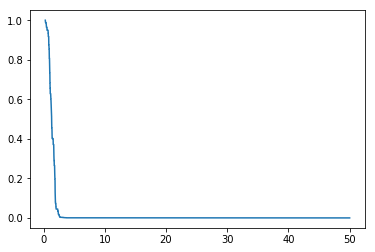

predict death
[1.9125 1.9153]

8.8833
False


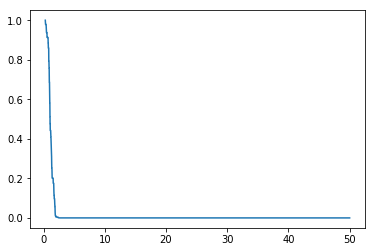

predict death
[1.7361 1.7382 1.7438 1.7465 1.7486 1.7771 1.7785 1.7826 1.7979]

8.1208
False


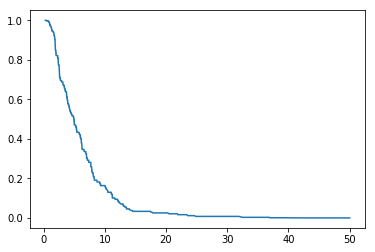

6.1063
False


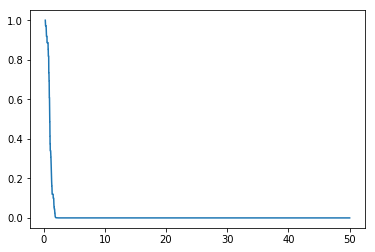

predict death
[1.5715 1.5792 1.5965 1.6007 1.6326 1.6521 1.6542 1.6549 1.6556]

5.8479
False


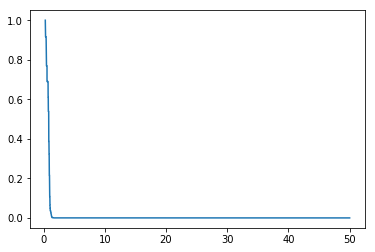

predict death
[0.9972 0.9993 1.0056 1.0153 1.0285]

4.8549
False


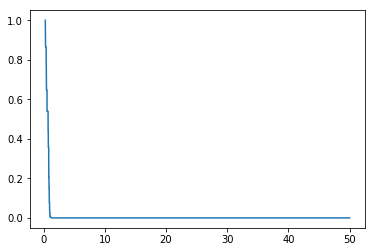

predict death
[0.9201]

21.209
False


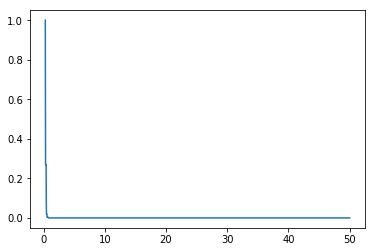

predict death
[0.4479]

1.7236
True


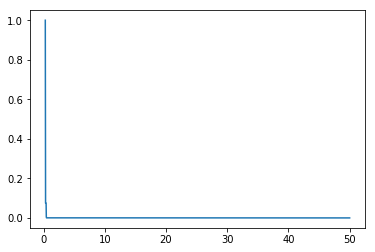

predict death
[0.3271 0.4153]

5.8792
False


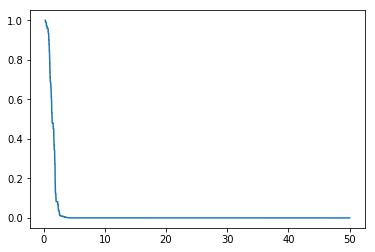

predict death
[2.0063 2.0083 2.0111 2.016  2.0215 2.0264 2.0313]

2.0833
False


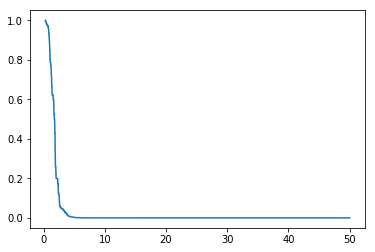

predict death
[2.5465 2.55  ]

2.6153
False


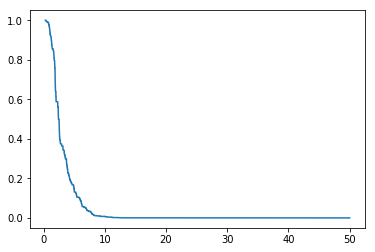

21.9354
True


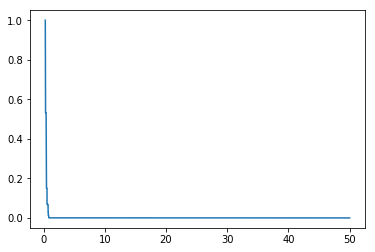

predict death
[0.5646 0.6646 0.7049 0.709  0.7194 0.7333]

23.6875
False


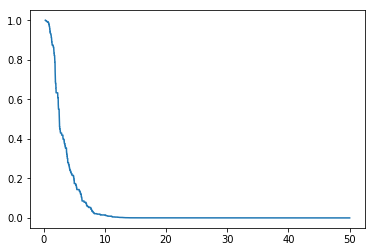

0.5056
True


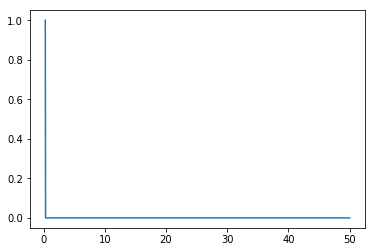

predict death
[0.3271 0.4153]

7.0778
False


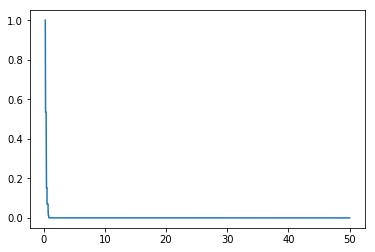

predict death
[0.5646 0.6646 0.7049 0.709  0.7194 0.7333]

1.6847
False


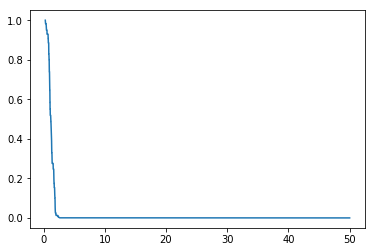

predict death
[1.8479 1.8493 1.8556 1.8694]

4.9181
False


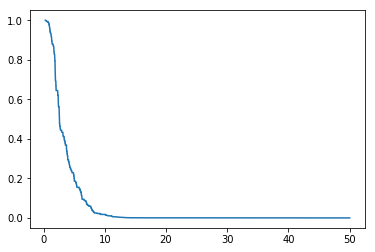

3.5979
False


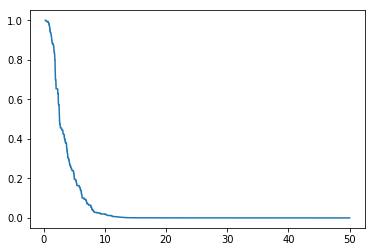

0.6549
True


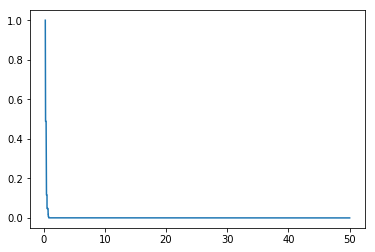

predict death
[0.4764 0.5049 0.5118 0.5354 0.5563 0.5625]

1.8549
False


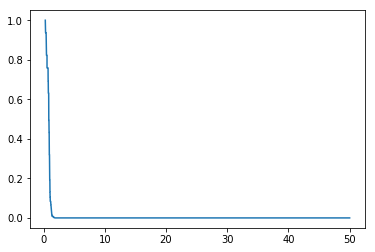

predict death
[1.0597 1.0833]

12.4285
True


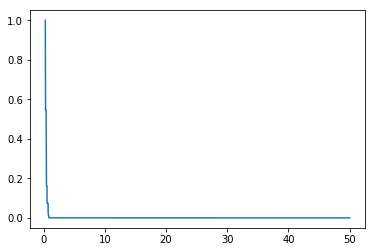

predict death
[0.5646 0.6646 0.7049 0.709  0.7194 0.7333]

4.0146
False


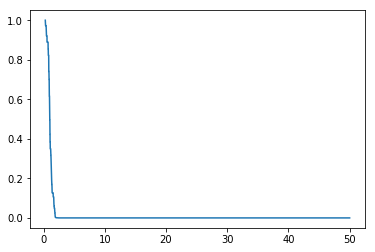

predict death
[1.5715 1.5792 1.5965 1.6007 1.6326 1.6521 1.6542 1.6549 1.6556]



In [432]:
for i in range(100):
    print(y_test['Survival_in_days'][i])
    print(y_test['Status'][i])
    fun = survival[i]
    plt.figure()
    plt.plot(fun.x, fun.y)
    plt.show()
#     print(fun.y)
    
    minvaluey = min(fun.y)
    if (minvaluey < 1e-20):
        print('predict death')
        given_value = 0.1
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_idx = min(fun.y, key=absolute_difference_function)
        print(fun.x[fun.y == closest_idx])
        print()

# fun1 = survival[0]
# print(fun1)
# print(fun1.x)
# print(fun1.y)
# plt.plot(fun1.x, fun1.y)
# print(y_test['Survival_in_days'][0])

# fun1 = survival[1]
# print(fun1)
# print(fun1.x)
# print(fun1.y)
# plt.plot(fun1.x, fun1.y)
# print(y_test['Survival_in_days'][1])

In [433]:
from sksurv.metrics import concordance_index_censored
metric = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], y_pred)
print(metric)

(0.48676258223244373, 9101, 9596, 0, 0)


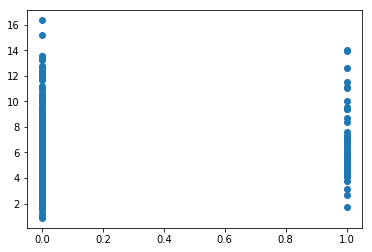

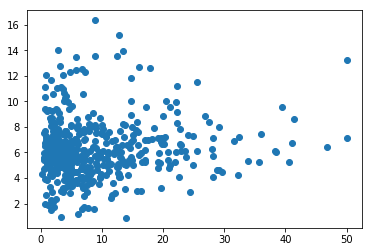

[ 7.60026722 12.61155496  7.07157113  5.83401325  8.12715867  5.72135749
  4.2825502   5.8930119   1.75904806  5.25982141  7.18937006  5.64008895
  4.14986545  6.33473919  6.04219656  4.59451066  6.42499055  6.08964908
  6.28516627  3.62372329  7.7835397   5.7496832  11.2076468   5.38587578
  5.67058664  8.23012748  6.29057117  7.4739266   5.79064711  5.54492041
  5.66219816  5.71062984  9.38497967  7.41563027  6.58938859  3.89021234
  9.53389891  4.8968602   3.96225438  8.70989996  8.37139138  5.56219807
  9.3518342   4.01248234  4.47329788  7.51958789  5.79801852  5.57821479
  5.55006212 15.19185477  5.3829456   4.20095844  4.05129861  4.85077936
  8.2755402   8.89792721  6.06332456  6.18314085  9.15159231  7.32917398
  8.8162462   2.15683219  6.13568957  7.63470376  7.03341837  6.89310027
 16.34062538  1.64916735  4.73843751  7.80864282  8.32648251  5.16662343
  2.67850371  9.66187443  6.02809566  3.35680558  4.8537071   7.87308664
  4.75447194 13.57582262  4.22186303  7.83710271  3

In [434]:
plt.figure()
# print(y_test['Status'])
plt.plot(y_test['Status'], y_pred, 'o')
plt.show()

plt.figure()
plt.plot(y_test['Survival_in_days'], y_pred, 'o')
plt.show()

print(y_pred)

In [435]:
# For other survival models that do not rely on the proportional hazards assumption, 
# it is often impossible to estimate survival or cumulative hazard function. Their 
# predictions are risk scores of arbitrary scale. If samples are ordered according 
# to their predicted risk score (in ascending order), one obtains the sequence of 
# events, as predicted by the model. This is the return value of the predict() method
# of all survival models in scikit-survival.


# Ranking the risk scores in ascending order
pred_ranks = np.argsort(y_pred)
print(pred_ranks)

test_ranks = np.argsort(-1*y_test['Survival_in_days'])
print(test_ranks)

[322 273 227  93 444 199  67 113   8 171 393  61 110 165 324 341  72 181
  83 228 442 229 315 403 207 283 195 231 480 440 132 443 352 457 423  75
 226 253 501 204 310  94 498  19 117 162 292 247 308 412 130 380  82  35
 439 319 391  38 168 328  43 173 490  52 414 222 249 107 481 262 387 102
  12 348 153  51 119  80 471 389 131 118   6 205 251 435 215 360 425 353
 150 154  44 279 494 316 297 138 429 116 376 447  15 208 496 408 323 375
 399 212 128 448 271 169 464  88  68 111 108 194  78 459 499 147 346 452
 209  53  76 405  37 148 180 136 185 221 500 255 240 259 307 411 235 174
 257 183 378 456 286 219 463 296 484 285 436 287  71 374 367 275 358 210
 321 379 120 122 451  89   9 141 466 288 218 245 170  92 101 211 155 486
 468 483 503  50 390  23 492 213 349 424 385 303 422 354 434 129 177 274
 449 491 395 201 206 400 398 462  29 100  48  41  47 142 461 276  90 125
 166 318  11 220  30 144  24 313 127 149 406  31   5 347 369 239  21 489
  28 383 269  46  95  85 470 267 325 301   3 344 32

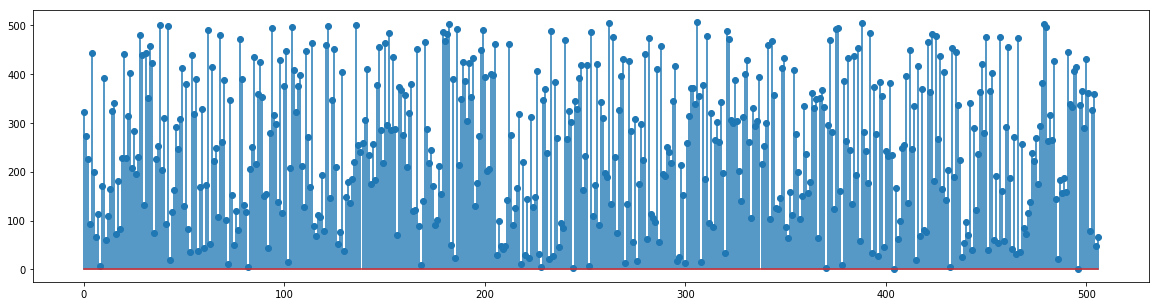

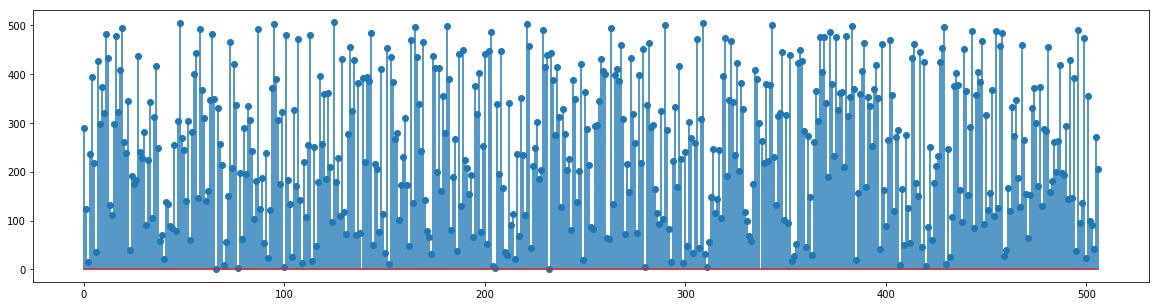

In [436]:
plt.figure(figsize=(20,5))
plt.stem(pred_ranks)
plt.show()

plt.figure(figsize=(20,5))
plt.stem(test_ranks)
plt.show()

Text(0, 0.5, 'Predicted Risk Score')

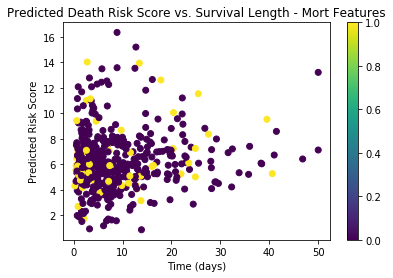

In [437]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

y_pred_scaled = scaler1.fit_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler2.fit_transform(y_test['Survival_in_days'].reshape(-1, 1))

plt.figure()
# plt.scatter(y_test['Survival_in_days'], y_pred, c=[not i for i in y_test['Status']])
plt.scatter(y_test['Survival_in_days'], y_pred, c=y_test['Status'])
classes = ListedColormap(['Death','Survival'])
plt.colorbar() # 1 (Death) is yellow, 0 (Survival) is purple
if mort_features:
    plt.title('Predicted Death Risk Score vs. Survival Length - Mort Features')
elif los_features:
    plt.title('Predicted Death Risk Score vs. Survival Length - LOS Features')
else:
    plt.title('Predicted Death Risk Score vs. Survival Length - All Features')
plt.xlabel('Time (days)')
plt.ylabel('Predicted Risk Score')

# Random Survival Forest

In [482]:
# Loading data
mort = pd.read_csv('../data/apache_patient_result_data.csv')
finGCS = pd.read_csv('../data/loaded/final_gcs.csv')
finGCS = finGCS.loc[:, ['patientunitstayid', 'Value']]
mort = mort.drop_duplicates('patientunitstayid')
mort['death'] = mort['actualhospitalmortality'] != 'ALIVE'
mort['los'] = mort['actualhospitallos'].astype(float)
mort = mort.loc[:, ['patientunitstayid', 'death', 'los']]
mort = mort.merge(finGCS, on = 'patientunitstayid', how = 'left')
mort = mort.dropna()
mort['GCS'] = mort['Value'] != 6
# display(mort)

losAlive = mort[mort['death'] == False].loc[:, ['los']].values
losDeath = mort[mort['death'] == True].loc[:, ['los']].values
# plt.figure(figsize = (8, 8))
# plt.boxplot([losAlive, losDeath], labels = ["Alive", "Dead"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs mortality", size = 16)
# plt.ylim((0, 25))
#plt.savefig("LOSvsMort.png", bbox_inches = 'tight')

# mort = mort[mort['death']]
# display(mort)


los1 = mort[mort['Value'] == 1].loc[:, ['los']].values
los2 = mort[mort['Value'] == 2].loc[:, ['los']].values
los3 = mort[mort['Value'] == 3].loc[:, ['los']].values
los4 = mort[mort['Value'] == 4].loc[:, ['los']].values
los5 = mort[mort['Value'] == 5].loc[:, ['los']].values
los6 = mort[mort['Value'] == 6].loc[:, ['los']].values

# plt.figure(figsize = (8, 8))
# plt.boxplot([los1, los2, los3, los4, los5, los6], labels = ["1", "2", "3", "4", "5", "6"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs final GCS", size = 16)
# plt.ylim((0, 35))
#plt.savefig("LOSvsGCS.png", bbox_inches = 'tight')

In [498]:
# Settings
mort_features = False
los_features = True

In [499]:
# Gathering the rest of data
ap = pd.read_csv('../data/loaded/processed/aperiodic_processed.csv')
ap = ap.iloc[:, [0, 2, 3, 4]]
ap = ap.set_index('patientunitstayid').add_prefix("AP_")

dem = pd.read_csv('../data/loaded/processed/dem_processed.csv')
dem = dem.set_index('patientunitstayid').add_prefix("DEM_")

inf = pd.read_csv('../data/loaded/processed/infusion_processed.csv')
inf = inf.set_index('patientunitstayid').add_prefix("INF_")

lab = pd.read_csv('../data/loaded/processed/lab_processed.csv')
lab = lab.set_index('patientunitstayid').add_prefix("LAB_")

med = pd.read_csv('../data/loaded/processed/medication_processed.csv')
med = med.set_index('patientunitstayid').add_prefix("MED_")

nc = pd.read_csv('../data/loaded/processed/nc_processed.csv')
nc['verbal'][nc['verbal'] > 6] = 6
nc['eyes'][nc['eyes'] > 6] = 6
nc = nc.iloc[:, [0, 2, 3, 4]]
nc = nc.fillna(nc.mean())
nc = nc.set_index('patientunitstayid').add_prefix("NC_")

resp = pd.read_csv('../data/loaded/processed/respiratory_processed.csv')
pd.set_option('display.max_columns', None)
resp.iloc[:, 1:] = resp.iloc[:, 1:] > 0
resp['entries'] = resp.iloc[:, 1:].sum(axis = 1) > 0
resp = resp.iloc[:, [0, 27]]
resp = resp.set_index('patientunitstayid').add_prefix("resp_")

X_ts = pd.read_csv('../data/loaded/processed/ts_processed.csv')
X_hr = X_ts[['patientunitstayid', 'offset_bin', 'hr']].pivot(index='patientunitstayid',
            columns='offset_bin', values='hr').reset_index()
X_resp = X_ts[['patientunitstayid', 'offset_bin', 'resp']].pivot(index='patientunitstayid',
            columns='offset_bin', values='resp').reset_index()
X_sao2 = X_ts[['patientunitstayid', 'offset_bin', 'sao2']].pivot(index='patientunitstayid',
            columns='offset_bin', values='sao2').reset_index()
X_gcs = X_ts[['patientunitstayid', 'offset_bin', 'gcs']].pivot(index='patientunitstayid',
            columns='offset_bin', values='gcs').reset_index()
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] > 6] = 6
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] < 1] = 1

pca = PCA(n_components = 5)
hrp = pca.fit_transform(X_hr.iloc[:, 1:])
respp = pca.fit_transform(X_resp.iloc[:, 1:])

sao2p = pca.fit_transform(X_sao2.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("sao2 PCA 0")
# plt.stem(pca.components_[0, :])

gcsp = pca.fit_transform(X_gcs.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("GCS PCA 0")
# plt.stem(pca.components_[0, :])


hr = pd.DataFrame(hrp)
hr.columns = ['hr0', 'hr1', 'hr2', 'hr3', 'hr4']
hr['patientunitstayid'] = X_hr['patientunitstayid']

resp = pd.DataFrame(respp)
resp.columns = ['resp0', 'resp1', 'resp2', 'resp3', 'resp4']
resp['patientunitstayid'] = X_resp['patientunitstayid']

sao2 = pd.DataFrame(sao2p)
sao2.columns = ['sao20', 'sao21', 'sao22', 'sao23', 'sao24']
sao2['patientunitstayid'] = X_sao2['patientunitstayid']

gcs = pd.DataFrame(gcsp)
gcs.columns = ['gcs0', 'gcs1', 'gcs2', 'gcs3', 'gcs4']
gcs['patientunitstayid'] = X_gcs['patientunitstayid']

X = gcs.set_index('patientunitstayid').merge(hr.set_index('patientunitstayid'), how = 'left', left_index = True, right_index = True).merge(resp.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True).merge(sao2.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True)
Xn = X.merge(nc, how = 'left',left_index = True, right_index = True).merge(med,  how = 'left',left_index = True, right_index = True).merge(lab, how = 'left',left_index = True, right_index = True).merge(inf,  how = 'left',left_index = True, right_index = True).merge(dem,  how = 'left',left_index = True, right_index = True).merge(ap,  how = 'left',left_index = True, right_index = True)

# Mort Features
if mort_features:
    Xn = Xn[['DEM_age', 'gcs0', 'INF_norepinephrine','INF_morphine', 'LAB_BUN', 'LAB_glucose', 'sao20', 'INF_phenylephrine', 'MED_4846.0', 'LAB_paCO2']]

# LOS Features
elif los_features:
    Xn = Xn[['gcs0', 'MED_549.0', 'MED_2102.0', 'MED_1326.0', 'MED_25386.0', 'LAB_HCO3', 'LAB_Hct', 'LAB_O2 Sat (%)', 'LAB_Hgb', 'LAB_-lymphs']]

Xn = Xn.reset_index()

#out = GCS, los, death
out = "los"
Y = Xn.merge(mort)[out].values
Xns = Xn.merge(mort).iloc[:, :-4]
Xns = Xns.fillna(Xns.mean())
display(Y)
display(Xns)

X = Xns.drop('patientunitstayid', axis = 1).values
Xn = Xns.drop('patientunitstayid', axis = 1)

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([ 6.9319,  6.8625, 10.0014, ...,  7.6736, 14.9396,  4.1521])

,patientunitstayid,gcs0,MED_549.0,MED_2102.0,MED_1326.0,MED_25386.0,LAB_HCO3,LAB_Hct,LAB_O2 Sat (%),LAB_Hgb,LAB_-lymphs
0,172448,21.395486,1.0,0.0,0.0,0.0,30.0,31.9,27.25,11.15,8.00
1,242714,-3.097281,0.0,0.0,1.0,0.0,12.6,36.1,12.60,12.00,11.30
2,242825,-3.097281,0.0,0.0,1.0,0.0,26.5,29.7,89.35,9.60,8.80
3,243176,-3.097281,0.0,0.0,1.0,0.0,14.0,31.4,14.00,10.30,3.70
4,243493,-3.097281,0.0,0.0,1.0,1.0,15.0,44.4,15.00,15.20,10.60
...,...,...,...,...,...,...,...,...,...,...,...
1684,3350835,-3.097281,1.0,0.0,1.0,0.0,24.3,35.0,96.00,11.90,25.15
1685,3351268,-3.097281,0.0,0.0,1.0,0.0,20.0,36.0,20.00,12.70,20.00
1686,3351909,-3.097281,0.0,0.0,1.0,1.0,24.0,37.0,24.00,12.60,24.00
1687,3352618,-3.097281,1.0,1.0,1.0,0.0,22.1,34.0,99.00,11.70,23.00


In [500]:
# Getting y values
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])
y = np.array([(death[i], los[i]) for i in range(len(death))], dtype=[('Status', 'bool'), ('Survival_in_days', 'float')])

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,242714,False,6.8625,6.0,False
2,242825,False,10.0014,6.0,False
3,243176,False,6.5340,6.0,False
4,243493,False,2.5028,6.0,False
...,...,...,...,...,...
1684,3350835,False,6.0063,6.0,False
1685,3351268,False,8.2465,6.0,False
1686,3351909,False,7.6736,6.0,False
1687,3352618,False,14.9396,6.0,False


In [505]:
# Trying random survival forest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest

yclass = np.array(death)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=6)
trainpredsss = []
testpredsss = []
trainlabsss = []
testlabsss = []
i = 0

best_y_pred = []
best_concordance = 0

metrics = []
scaler = StandardScaler()
for train_index, test_index in sss.split(X, yclass):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rsf = RandomSurvivalForest(n_estimators=10)
    rsf.fit(X_train, y_train)
    y_pred = rsf.predict(X_test)
    metric = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], y_pred)
    metrics.append(metric)
    if (metric[0] > best_concordance):
        best_concordance = metric[0]
        best_y_pred = y_pred
        
y_pred = best_y_pred

print('Best Concordance: ' + str(best_concordance))

concordances = [m[0] for m in metrics]
print('Average Concordance: ' + str(np.mean(concordances)))

Best Concordance: 0.8589975221969853
Average Concordance: 0.8518609338503431


Text(0, 0.5, 'Predicted Risk Score')

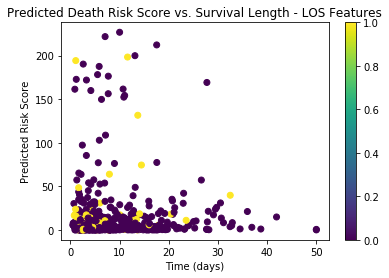

In [506]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

y_pred_scaled = scaler1.fit_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler2.fit_transform(y_test['Survival_in_days'].reshape(-1, 1))

plt.figure()
# plt.scatter(y_test['Survival_in_days'], y_pred, c=[not i for i in y_test['Status']])
plt.scatter(y_test['Survival_in_days'], y_pred, c=y_test['Status'])
classes = ListedColormap(['Death','Survival'])
plt.colorbar() # 1 (Death) is yellow, 0 (Survival) is purple
if mort_features:
    plt.title('Predicted Death Risk Score vs. Survival Length - Mort Features')
elif los_features:
    plt.title('Predicted Death Risk Score vs. Survival Length - LOS Features')
else:
    plt.title('Predicted Death Risk Score vs. Survival Length - All Features')
plt.xlabel('Time (days)')
plt.ylabel('Predicted Risk Score')